# **TAREA 3 Inteligencia Artificial**

---


##  IIC2613- Inteligencia Artificial
### **Docente**: Jorge Baier.
#### **Alumno**: Nicolás Sumonte. Numero de Alumno: 17627478

In [ ]:
!gdown --id 1rR0CjYZDgMfZDVYlyPxJdYpDN1XH5AYq

Downloading...
From: https://drive.google.com/uc?id=1rR0CjYZDgMfZDVYlyPxJdYpDN1XH5AYq
To: /content/mini_fer2013.csv
144MB [00:00, 255MB/s]


In [ ]:
!pip install face_recognition

➼ Cargamos las librerias a utilizar durante la ejecución del problema

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import procrustes, distance
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import face_recognition as fr
import numpy as np
import cv2
from ast import literal_eval

➼ Para comenzar, cargamos y procesamos los datos de forma conveniente

In [ ]:
df = pd.read_csv('/content/mini_fer2013.csv')

In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,ToV
1,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,ToV
2,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,ToV
3,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,ToV
4,0,30 24 21 23 25 25 49 67 84 103 120 125 130 139...,ToV


In [ ]:
lista_emociones = ['enojo', 'asco', 'miedo', 'alegria', 'tristeza', 'sorpresa', 'neutral']
df_emotions = pd.DataFrame(lista_emociones, columns=['emotion_name'])
df_emotions['index_col'] = df_emotions.index
df_TOV = df[df.Usage=='ToV']
df_test = df[df.Usage=='Test']
df_0 = df[df.emotion==0]
df_1 = df[df.emotion==1]
df_2 = df[df.emotion==2]
df_3 = df[df.emotion==3]
df_4 = df[df.emotion==4]
df_5 = df[df.emotion==5]
df_6 = df[df.emotion==6]

# **Pregunta 1**

---



➼  A continuacion se muestran las imagenes por cada emoción. Procesadas con la librería **OpenCv** la cual, es una biblioteca de software de visión artificial y aprendizaje automático de código abierto. OpenCV se creó para proporcionar una infraestructura común para aplicaciones de visión por computadora y para acelerar el uso de la percepción de la máquina.

➼  Tambien existen otras librerias para el procesamiento de imagenes, como lo son **Pillow**, **Scipy** y **Scikit-Image** con los mismos fines. Sin embargo, he decidido utilizar Opencv por su facilidad en la forma de trabajo.

In [ ]:
def mostrar_imagen(pixel,emotion):
  a = list(map(int, pixel.split(' ')))[:48 * 48]
  i = np.array(a).reshape((48, 48)).astype('uint8')
  gary2rgb = cv2.cvtColor(i,cv2.COLOR_GRAY2RGB)
  resized_image = cv2.resize(gary2rgb, (200, 200)) 
  fig1 = plt.figure(0)
  fig1.suptitle(f'{emotion}', fontsize=10)
  foto = plt.imshow(resized_image)
  return resized_image

def proc_landmarks(image):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.set_title('con landmarks')
  ax1.imshow(image, aspect="auto")
  image1 = fr.face_landmarks(image)
  for key in image1:
    for k in key:
      for j in key[k]:
        if 0<j[0] <200 and 0<j[1] < 200:
          ax1.scatter(j[0],j[1],c='#25B7BE',s=5)
  ax2.set_title('landmarks', fontsize=10)
  plt.gca().invert_yaxis()
  for key in image1:
    for k in key:
      for j in key[k]:
        if 0< j[0] <200 and 0<j[1] < 200:
          ax2.scatter(j[0],j[1],c='#25B7BE',s=5)

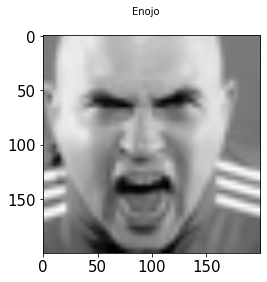

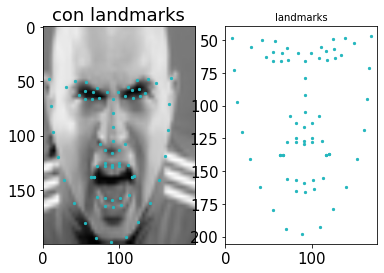

In [ ]:
pixel = df_0.iloc[2]['pixels']
emotion = 'Enojo'
resize = mostrar_imagen(pixel,emotion)
proc_landmarks(resize)

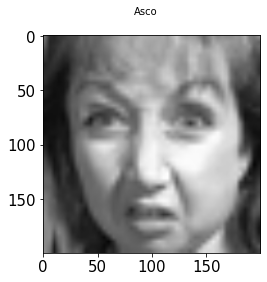

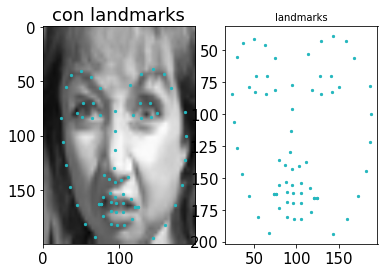

In [ ]:
pixel = df_1.iloc[1]['pixels']
emotion = 'Asco'
resize = mostrar_imagen(pixel,emotion)
proc_landmarks(resize)

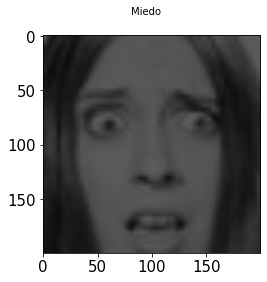

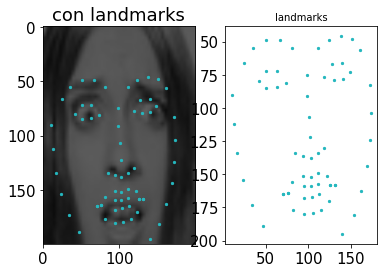

In [ ]:
pixel = df_2.iloc[1]['pixels']
emotion = 'Miedo'
resize = mostrar_imagen(pixel,emotion)
proc_landmarks(resize)

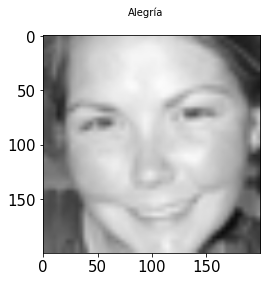

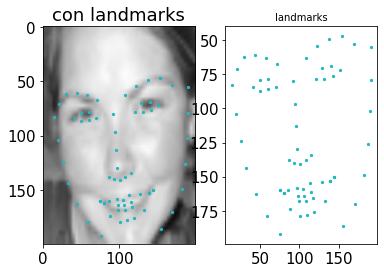

In [ ]:
pixel = df_3.iloc[1]['pixels']
emotion = 'Alegría'
resize = mostrar_imagen(pixel,emotion)
proc_landmarks(resize)

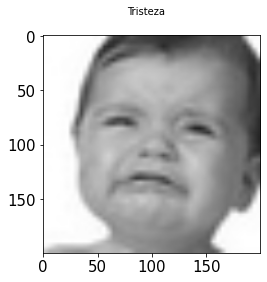

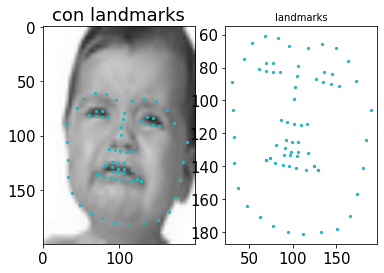

In [ ]:
pixel = df_4.iloc[1]['pixels']
emotion = 'Tristeza'
resize = mostrar_imagen(pixel,emotion)
proc_landmarks(resize)

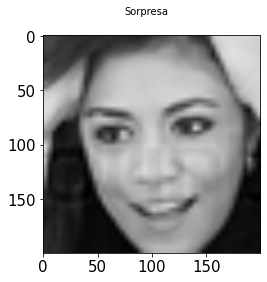

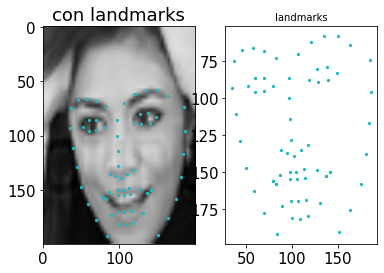

In [ ]:
pixel = df_5.iloc[2]['pixels']
emotion = 'Sorpresa'
resize = mostrar_imagen(pixel,emotion)
proc_landmarks(resize)

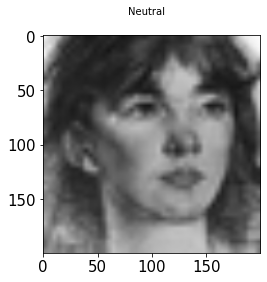

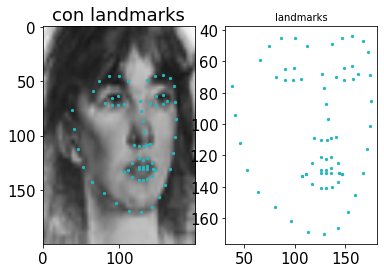

In [ ]:
pixel = df_6.iloc[2]['pixels']
emotion = 'Neutral'
resize = mostrar_imagen(pixel,emotion)
proc_landmarks(resize)

#**Pregunta 2**

---



➼ Para entrenar el modelo haré uso de los **landmarks** entregados por la función `face_landmarks` para cada imagen. Por lo mismo, es necesario pre procesar todos los datos obtenidos. La función `proc_matriz`, retorna un Dataframe que contiene una columna correspondiente a la emoción, los pixeles de los landmarks y por último el uso que se le dará a cada entrada.

In [ ]:
def proc_matriz(dataframe):
  df_processed = pd.DataFrame(columns=['emotions','pixels','landmark','Usage'])
  for index, row in dataframe.iterrows():
    pixel = row['pixels']
    emotions = row['emotion']
    a = list(map(int, pixel.split(' ')))[:48 * 48]
    i = np.array(a).reshape((48, 48)).astype('uint8')
    gary2rgb = cv2.cvtColor(i,cv2.COLOR_GRAY2RGB)
    resized_image = cv2.resize(gary2rgb, (250, 250)) 
    image1 = fr.face_landmarks(resized_image)
    lista_landmarks=[]
    for key in image1:
        for k in key:
          list_keys = key[k]
          for i in list_keys:
            lista_landmarks.append(i)
    if len(lista_landmarks) == 72:
      landmarks_str = " ".join(str(x) for x in lista_landmarks)
      df_processed = df_processed.append({'emotions': emotions, 'pixels' : row['pixels'], 'landmark': landmarks_str, 'Usage': row['Usage']}, ignore_index=True)
  return df_processed

In [ ]:
df_proc_enojo = proc_matriz(df_0)
df_proc_asco = proc_matriz(df_1)
df_proc_miedo = proc_matriz(df_2)
df_proc_alegria = proc_matriz(df_3)
df_proc_tristeza = proc_matriz(df_4)
df_proc_sorpresa = proc_matriz(df_5)
df_proc_neutral = proc_matriz(df_6)
df_proc_general = pd.concat([df_proc_enojo, df_proc_asco, df_proc_miedo, df_proc_alegria, df_proc_tristeza, df_proc_sorpresa, df_proc_neutral],axis=0)

➼ Para poder eliminar datos atipicos y con ello, procesar de mejor manera los datos y hacer inferencias correctas, haré uso de la técnica de análisis Multivariado llamada [Análisis de Procrustes](https://en.wikipedia.org/wiki/Procrustes_analysis). La cual explicaré a continuación:

➼ Consideremos los puntos: 
$$P_{i,j}$$
en donde i y j representan las correspondientes coordenadas cartesianas. Así se pueden trasladar, rotar, reflejar o escalar los puntos  para minimizar el criterio de máximo ajuste con respecto a un centroide  $G_{i,j}$. 

Es decir, es una tecnica que  busca minimizar $$\sum_{i=1}^{n} \sum_{j=1}^{m} (P_{i,j} - G_{i,j})^{2}$$
Por lo tanto, se escogerá como centroide referencia el promedio de todos los puntos por cada emoción y se eliminarán los puntos que se encuentren a una diferencia muy grande. Por lo mismo, la función `calculate_mean` calcula el promedio por cada emoción y `filtrate_df` filtra los datos segun el criterio anteriormente explicados.

In [ ]:
def calculate_mean(df_to_use):
  obj_x = {}
  for i in range(1, 73):
    obj_x[str(i)] = 0
  obj_y = {}
  for k in range(1,73):
    obj_y[str(k)] = 0

  for index,row in df_to_use.iterrows():
    i=1
    k=1
    landmarks = [literal_eval(f'[{x}]') for x in row['landmark'].strip('()').split(') (')]
    xs = [x[0] for x in landmarks]
    for x in xs:
      obj_x[f'{i}'] += int(x)
      i+=1
    ys = [x[1] for x in landmarks]
    for y in ys:
      obj_y[f'{k}'] += int(y)
      k+=1
  ds = [obj_x, obj_y]
  d = {}
  list_average = []
  for k in obj_x.keys():
    d[k] = tuple(d[k] for d in ds)
  for i in range(1,73):
    list_points = []
    val_x = float(d[f'{i}'][0] / len(df_to_use.index))
    list_points.append(val_x)
    val_y = float(d[f'{i}'][1] / len(df_to_use.index))
    list_points.append(val_y)
    list_average.append(list_points)
  return list_average

In [ ]:
def filtrate_df(df_to_use,list_average):
  df_ajusted = pd.DataFrame(columns=['emotions','pixels','landmark','Usage'])
  for index,row in df_to_use.iterrows():
    landmarks = [literal_eval(f'({x})') for x in row['landmark'].strip('()').split(') (')]
    R,s = orthogonal_procrustes(np.array(list_average),np.array(landmarks))
    mtx1, mtx2, disparity = procrustes(np.array(list_average),np.array(landmarks))
    transf_landmarks = np.dot(np.array(landmarks), R.T)
    if disparity < 0.01:
      landmarks_str = " ".join(str(x) for x in landmarks)
      df_ajusted = df_ajusted.append({'emotions': row['emotions'],'pixels':row['pixels'],'landmark': landmarks_str, 'Usage': row['Usage']}, ignore_index=True)
  return df_ajusted

➼  A continuación se filtran todas las bases de datos anteriormente construidas con el criterio

In [ ]:
list_average_enojo = calculate_mean(df_proc_enojo)
df_ajusted_enojo = filtrate_df(df_proc_enojo,list_average_enojo)

list_average_asco = calculate_mean(df_proc_asco)
df_ajusted_asco = filtrate_df(df_proc_asco,list_average_asco)

list_average_miedo = calculate_mean(df_proc_miedo)
df_ajusted_miedo = filtrate_df(df_proc_miedo,list_average_miedo)

list_average_alegria = calculate_mean(df_proc_alegria)
df_ajusted_alegria = filtrate_df(df_proc_alegria,list_average_alegria)

list_average_tristeza = calculate_mean(df_proc_tristeza)
df_ajusted_tristeza = filtrate_df(df_proc_tristeza,list_average_tristeza)

list_average_sorpresa = calculate_mean(df_proc_sorpresa)
df_ajusted_sorpresa = filtrate_df(df_proc_sorpresa,list_average_sorpresa)

list_average_neutral = calculate_mean(df_proc_neutral)
df_ajusted_neutral = filtrate_df(df_proc_neutral,list_average_neutral)

df_ajusted_general = pd.concat([df_ajusted_enojo, df_ajusted_asco, df_ajusted_miedo, df_ajusted_alegria, df_ajusted_tristeza, df_ajusted_sorpresa, df_ajusted_neutral],axis=0)
list_average_general = calculate_mean(df_ajusted_general)

➼  Ahora graficamos la diferencia de los datos antes del procesamiento y despues del procesamiento para cada emoción. (La función `graf_scatter` lo realiza). En los puntos negros se encuentra el promedio de todos los landmarks y en celeste todas las observaciones.

In [ ]:
def graf_scatter(df_original,df_to_use,mean_list,emocion):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle(f'diferencias en {emocion}', fontsize=16)
  for index,row in df_to_use.iterrows():
    landmarks = [literal_eval(f'[{x}]') for x in row['landmark'].strip('()').split(') (')]
    xs = [x[0] for x in landmarks]
    ys = [x[1] for x in landmarks]
    x_prom = [x[0] for x in mean_list]
    y_prom = [x[1] for x in mean_list]
    ax1.scatter(xs, ys, c='#25B7BE', s=0.1)
    ax1.scatter(x_prom, y_prom,c='black', s=20)
  for index,row in df_original.iterrows():
    landmarks = [literal_eval(f'[{x}]') for x in row['landmark'].strip('()').split(') (')]
    xs = [x[0] for x in landmarks]
    ys = [x[1] for x in landmarks]
    ax2.scatter(xs, ys, c='#25B7BE', s=0.1)
    ax2.scatter(x_prom, y_prom,c='black', s=20)
  ax1.set_title('Sin Outliers')
  ax2.set_title('Con Outliers')
  ax2.invert_yaxis()
  ax1.invert_yaxis()

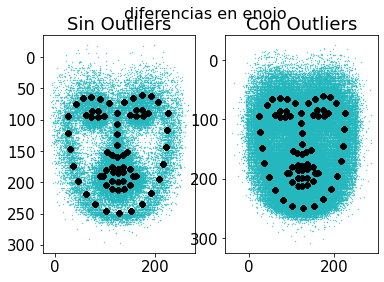

In [ ]:
graf_scatter(df_proc_enojo,df_ajusted_enojo,list_average_enojo, 'enojo')

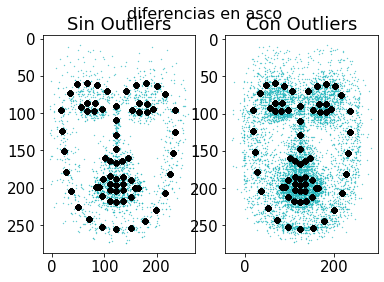

In [ ]:
graf_scatter(df_proc_asco,df_ajusted_asco,list_average_asco, 'asco')

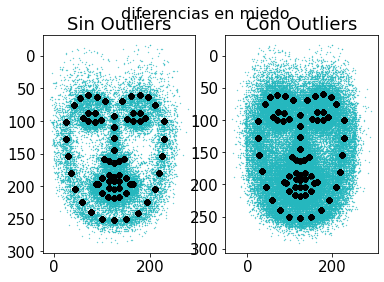

In [ ]:
graf_scatter(df_proc_miedo,df_ajusted_miedo,list_average_miedo, 'miedo')


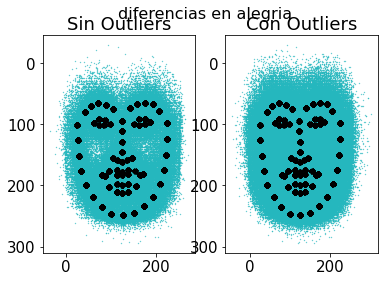

In [ ]:
graf_scatter(df_proc_alegria,df_ajusted_alegria,list_average_alegria, 'alegria')

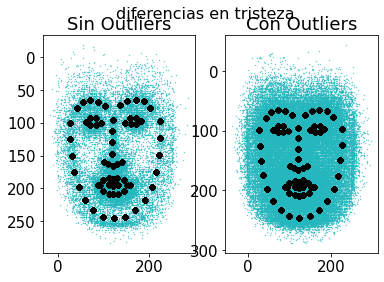

In [ ]:
graf_scatter(df_proc_tristeza,df_ajusted_tristeza,list_average_tristeza, 'tristeza')

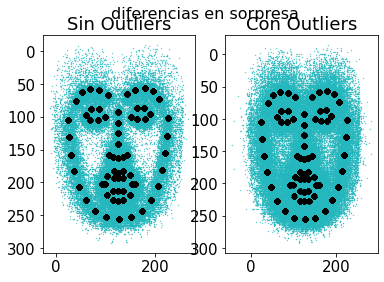

In [ ]:
graf_scatter(df_proc_sorpresa,df_ajusted_sorpresa,list_average_sorpresa, 'sorpresa')

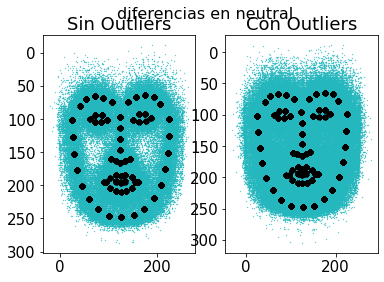

In [ ]:
graf_scatter(df_proc_neutral,df_ajusted_neutral,list_average_neutral, 'neutral')

➼ Es posible notar que se consiguieron datos que se asemejan mucho más a las caras de cada emoción y ya no hay una nube de puntos dispersa por cada cara. Es decir, hemos conseguido eliminar el ruido de las observaciones por lo tanto, ocuparemos los datos procesados para el entrenamiento.

➼  Ahora, separaremos los datos en Test y ToV y construiremos la matriz de covariables X considerando como variables explicativas la distancia entre cada par de puntos de la cara. Es decir, la matriz de covariables X tendrá una dimensión de:
$$Dim(X) = \frac{P*(P-1)}{2} \times n$$
en donde n es el numero de observaciones y P es la cantidad de landmarks. Es decir la matriz X tendra 2556 columnas.

➼ En cuanto a los vectores de variables respuestas (Y) se utilizó como etiqueta el numero correspondiente a cada emoción y se separó segun lo mencionado anteriormente.

In [ ]:
y_matrix = []
x_matrix = []
for index,row in df_ajusted_general[df_ajusted_general.Usage=='Test'].iterrows():
  y_val = row['emotions']
  lista_distancias = []
  lista_distancias_pares = []
  landmarks_ajusted = [literal_eval(f'[{x}]') for x in row['landmark'].strip('()').split(') (')]
  for k in range(0,72):
    for j in range(0,72):
      if j>k:
        break
      dis = distance.euclidean(landmarks_ajusted[k], landmarks_ajusted[j])
      lista_distancias_pares.append(dis)
  y_matrix.append(y_val)
  x_matrix.append(lista_distancias_pares)

In [ ]:
y_validation_matrix = []
x_validation_matrix = []
for index,row in df_ajusted_general[df_ajusted_general.Usage=='ToV'].iterrows():
  y_val = row['emotions']
  lista_distancias = []
  lista_distancias_pares = []
  landmarks_ajusted = [literal_eval(f'[{x}]') for x in row['landmark'].strip('()').split(') (')]
  for k in range(0,72):
    for j in range(0,72):
      if j>k:
        break
      dis = distance.euclidean(landmarks_ajusted[k], landmarks_ajusted[j])
      lista_distancias_pares.append(dis)
  y_validation_matrix.append(y_val)
  x_validation_matrix.append(lista_distancias_pares)

➼ Para separar los datos de ToV en *train set* y *validation set* , debemos tener en cuenta que aprender  los parámetros de la función predictiva y probarlos con los mismos datos es un error. Un modelo que simplemente repite los numeros de la variable respuesta de la muestra recién mostrada tendrá probablemente una puntuación perfecta, pero ante nuevas observaciones exisitirán altos niveles de incertidumbre. Esta situación se llama sobreajuste. Para evitar esto, es común separar los datos aleatoriamente en el conjunto de train, validate y test como muestra la imagen adjunta.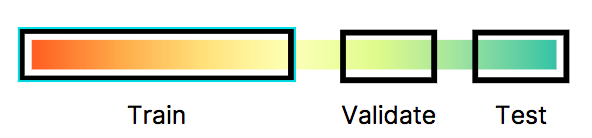

➼ Por lo mismo, separaré aleatoriamente los datos del conjunto ToV utilizando la función `train_test_split` de Sklearn. utilizando una muestra de train del 75% del tamaño de ToV y de validate al 25% tal como se recomienda en [[2]](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118874059).

In [ ]:
X_train,X_val, Y_train,Y_val = train_test_split(x_validation_matrix,y_validation_matrix)

➼  Con ello, nos quedan los siguientes resultados para cada set con dimensiones de vectores X e y anteriormente ya explicados:

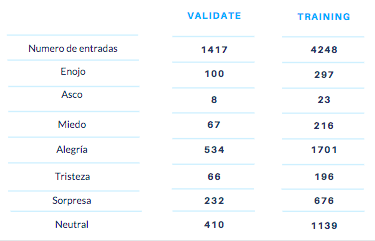







# **Pregunta 3**

---



➼ En esta parte, se evaluó el clasificador de **Support Vector Machine** con 5 valores de *Slack* (0.1,1,10 y 100) y 3 valores distintos para el *kernel* los cuales son rbf, sigmoide y polinomial. El clasificador de **arbol de decision** con valores de profundidad de (1,10,50,60,80,100,1000) y ambos valores de *criterion* y finalmente el **clasificador bayesiano** sin distribución a *priori*.

### SCV Kernel Rbf

In [ ]:
clf = SVC()
list_accur_normal = []
list_C = [0.1,1,10,100,1000]
for i in list_C:
  clf.set_params(C=i)
  clf.fit(X_train,Y_train)
  y_pred = clf.predict(X_val)
  acc = accuracy_score(Y_val, y_pred)
  list_accur_normal.append((i,acc))

[(0.1, 0.7614678899082569),
 (1, 0.8172194777699365),
 (10, 0.8390966831333804),
 (100, 0.8532110091743119),
 (1000, 0.8419195483415667)]

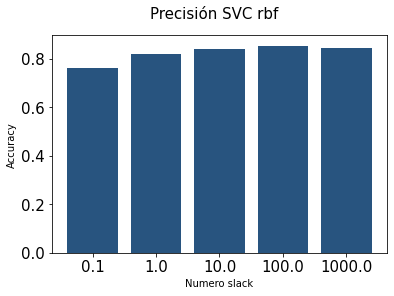

In [ ]:
fig = plt.figure()
x_accur_normal = [x[0] for x in list_accur_normal]
y_accur_normal = [x[1] for x in list_accur_normal]
fig.suptitle('Precisión SVC rbf', fontsize=15)
plt.xlabel('Numero slack', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.bar(['0.1','1','10','100','1000'],y_accur_normal,color ='#28547F',tick_label=x_accur_normal)
list_accur_normal

➼ Se puede apreciar que en este modelo, el mejor rendimiento se obtiene con variable slack de 100 con un *accuracy* de 85,32%.

###  SVC kernel Sigmoide

In [ ]:
clf = SVC()
list_C = [0.1,1,10,100,1000]
list_accur_linear = []
for i in list_C:
  clf.set_params(kernel='sigmoid',C=i)
  clf.fit(X_train,Y_train)
  y_pred = clf.predict(X_val)
  acc = accuracy_score(Y_val, y_pred)
  list_accur_linear.append((i,acc))

[(0.1, 0.3987297106563162),
 (1, 0.38108680310515175),
 (10, 0.3232180663373324),
 (100, 0.32251235003528583),
 (1000, 0.3232180663373324)]

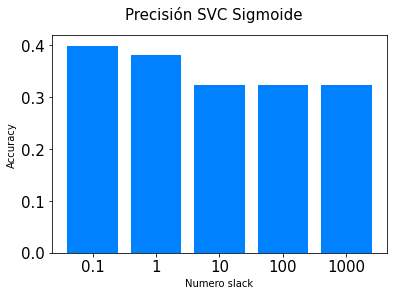

In [ ]:
fig = plt.figure()
x_accur_linear = [x[0] for x in list_accur_linear]
y_accur_linear = [x[1] for x in list_accur_linear]
fig.suptitle('Precisión SVC Sigmoide', fontsize=15)
plt.xlabel('Numero slack', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.bar(['0.1','1','10','100','1000'],y_accur_linear, color= '#0081FF')
list_accur_linear

➼ A pesar que la precisión del modelo es casi constante, se puede apreciar que en este modelo, el mejor rendimiento se obtiene con variable slack de 0.1 con un accuracy de 39,87%.

### SVC Kernel Polinomial

In [ ]:
clf = SVC()
list_accur_poly = []
list_C = [0.1,1,10,100,1000]
for i in list_C:
  clf.set_params(kernel='poly',C=i)
  clf.fit(X_train,Y_train)
  y_pred = clf.predict(X_val)
  acc = accuracy_score(Y_val, y_pred)
  list_accur_poly.append((i,acc))

[(0.1, 0.8270995059985886),
 (1, 0.8461538461538461),
 (10, 0.8553281580804517),
 (100, 0.8482709950599859),
 (1000, 0.826393789696542)]

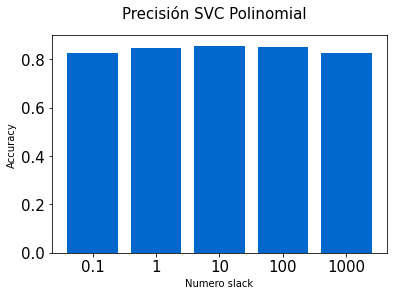

In [ ]:
fig = plt.figure()
fig.suptitle('Precisión SVC Polinomial', fontsize=15)
plt.xlabel('Numero slack', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
x_accur_poly = [x[0] for x in list_accur_poly]
y_accur_poly = [x[1] for x in list_accur_poly]
plt.bar(['0.1','1','10','100','1000'],y_accur_poly, color='#0067CC')
list_accur_poly

➼ A pesar que la precisión del modelo es casi constante se puede apreciar que en este modelo, el mejor rendimiento se obtiene con variable slack de 10 con un accuracy de 85,54%.

➼ Ahora si comparamos todos los modelos calculados, es posible observar que el mejor rendimiento se obtiene con el modelo RBF y valor de slack 100 con accuracy de 85,32%


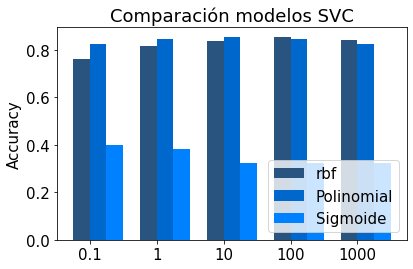

In [ ]:
labels = ['0.1','1','10','100','1000']
x = np.arange(len(labels)) 
y_accur_normal = [x[1] for x in list_accur_normal]
y_accur_poly = [x[1] for x in list_accur_poly]
y_accur_linear = [x[1] for x in list_accur_linear]
width = 0.25

fig, ax = plt.subplots()
recta1 = ax.bar(x - width/2, y_accur_normal, width= 0.25, label='rbf',color ='#28547F')
recta2 = ax.bar(x + width/2, y_accur_poly, width=0.25, label='Polinomial',color='#0067CC')
recta3 = ax.bar( x + 3*width/2, y_accur_linear, width=0.25, label='Sigmoide',color= '#0081FF')


ax.set_ylabel('Accuracy')
ax.set_title('Comparación modelos SVC')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

fig.tight_layout()

plt.show()

### Árbol de decision *Gini*

In [ ]:
clf_tree = DecisionTreeClassifier()
clf_tree_gini = []
list_C = [1,10,50,60,80,100,1000]
for i in list_C:
  clf_tree.set_params(criterion='gini',max_depth=i)
  clf_tree.fit(X_train,Y_train)
  y_pred = clf_tree.predict(X_val)
  acc = accuracy_score(Y_val, y_pred)
  clf_tree_gini.append((i,acc))

[(1, 0.5984474241354976),
 (10, 0.7685250529287226),
 (50, 0.7275935074100212),
 (60, 0.7346506704304869),
 (80, 0.7247706422018348),
 (100, 0.7374735356386732),
 (1000, 0.7367678193366267)]

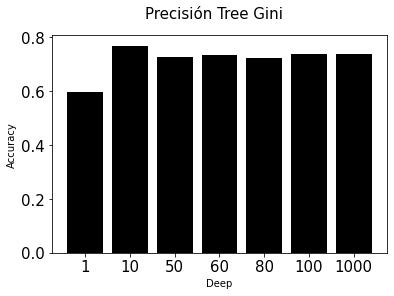

In [ ]:
fig = plt.figure()
x_tree_gini = [x[0] for x in clf_tree_gini]
y_tree_gini = [x[1] for x in clf_tree_gini]
fig.suptitle('Precisión Tree Gini', fontsize=15)
plt.xlabel('Deep', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.bar(['1','10','50','60','80','100','1000'],y_tree_gini, color= '#000000')
clf_tree_gini

➼ Bajo esta combinación de parametros, se obtiene mayor accuracy con profundidad 10. Con un valor de 76.85%

### Árbol de decisión *Entropy*

In [ ]:
clf_tree = DecisionTreeClassifier()
clf_tree_entropy = []
list_C = [1,10,50,60,80,100,1000]
for i in list_C:
  clf_tree.set_params(criterion='entropy',max_depth=i)
  clf_tree.fit(X_train,Y_train)
  y_pred = clf_tree.predict(X_val)
  acc = accuracy_score(Y_val, y_pred)
  clf_tree_entropy.append((i,acc))

[(1, 0.5984474241354976),
 (10, 0.7741707833450953),
 (50, 0.7494707127734651),
 (60, 0.7424135497529993),
 (80, 0.7452364149611856),
 (100, 0.757939308398024),
 (1000, 0.7565278757939309)]

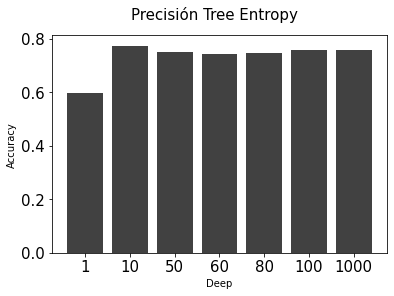

In [ ]:
fig = plt.figure()
x_tree_entropy = [x[0] for x in clf_tree_entropy]
y_tree_entropy = [x[1] for x in clf_tree_entropy]
fig.suptitle('Precisión Tree Entropy', fontsize=15)
plt.xlabel('Deep', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.bar(['1','10','50','60','80','100','1000'],y_tree_entropy, color= '#414141')
clf_tree_entropy

➼ Bajo esta combinación de parametros, se obtiene mayor accuracy con profundidad 10. Con un valor de 77.41%.

➼ Finalmente, si comparamos ambos modelos, obtenemos que el mejor valor se obtiene con *criterion* entropy y profundidad igual a 10.

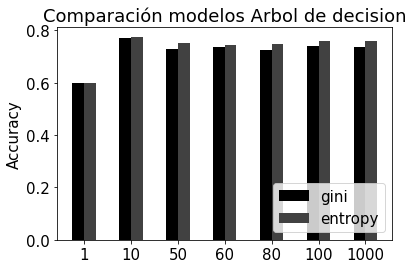

In [ ]:
labels = ['1','10','50','60','80','100','1000']
x = np.arange(len(labels)) 
y_tree_gini = [x[1] for x in clf_tree_gini]
y_tree_entropy = [x[1] for x in clf_tree_entropy]

width = 0.25

fig, ax = plt.subplots()
recta1 = ax.bar(x - width/2, y_tree_gini, width= 0.25, label='gini',color ='#000000')
recta2 = ax.bar(x + width/2, y_tree_entropy, width=0.25, label='entropy',color='#414141')

ax.set_ylabel('Accuracy')
ax.set_title('Comparación modelos Arbol de decision')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

fig.tight_layout()

plt.show()

### Clasificador Bayesiano

➼ El clasificador Bayesiano, retorna una precisión del 52,57%.

In [ ]:
clf_bayes = GaussianNB()
clf_bayes.fit(X_train,Y_train)
y_pred = clf_bayes.predict(X_val)
acc = accuracy_score(Y_val, y_pred)
print(acc)

0.5257586450247


➼ Ahora si realizamos una comparación de todos los criterios estudiados, obtenemos que los mejores resultados se obtienen en SVM con kernel = rbf y variable de stack de 100.

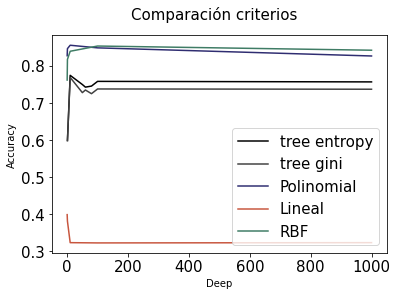

In [ ]:
fig = plt.figure()
x_tree_entropy = [x[0] for x in clf_tree_entropy]
y_tree_entropy = [x[1] for x in clf_tree_entropy]
x_tree_gini = [x[0] for x in clf_tree_gini]
y_tree_gini = [x[1] for x in clf_tree_gini]
x_accur_normal = [x[0] for x in list_accur_normal]
y_accur_normal = [x[1] for x in list_accur_normal]
x_accur_poly = [x[0] for x in list_accur_poly]
y_accur_poly = [x[1] for x in list_accur_poly]
x_accur_linear = [x[0] for x in list_accur_linear]
y_accur_linear = [x[1] for x in list_accur_linear]
fig.suptitle('Comparación criterios', fontsize=15)
plt.xlabel('Deep', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.plot(x_tree_entropy,y_tree_entropy, c='#000000', label='tree entropy')
plt.plot(x_tree_gini,y_tree_gini, c= '#414141', label='tree gini')
plt.plot(x_accur_poly,y_accur_poly, c='#2F2D71', label='Polinomial')
plt.plot(x_accur_linear,y_accur_linear, c= '#C8563E', label='Lineal')
plt.plot(x_accur_normal,y_accur_normal, c= '#3F7C65', label='RBF')
plt.legend(loc='lower right')

➼ En este problema SVM presenta muchas ventajas que hacen que posea mejor rendimiento:

1.   En primer lugar, se trata de un problema en que no tenemos tanta idea de la organización de los datos, en ese sentido, no sabemos si los datos se distribuyen normalmente ni si tienen una distribución conocida. Por lo mismos los kernels, nos ayudan a lograr parametrizar esta función, proporcionando la opción de utilizar distintos ajustes a los datos. Por el contrario cuando utilizamos el clasificador bayesiano asumimos en un comienzo la utilización de una distribución a priori plana (ó constante) lo que puede o no ser cierto, por lo tanto, esta una fuente de error en la predicción.

2.   Consideremos además que estamos en presencia de un problema de alta dimensión. Lo que le da un ventaja importante a SVM, esto debido a que sabemos que SVM no utliza todos los puntos de la matriz de diseño, sino solo los que le permiten formar los hiperplanos separadores entre los clasificadores. En cambio, el arbol de decisión dividen el espacio muestral en cada nodo. A medida que aumenta el espacio muestral, aumentan las distancias entre los puntos de datos, lo que hace que sea mucho más difícil encontrar una división "buena", y por lo mismo, obtiene un peor desempeño.

3. En tercer lugar, Los valores atípicos tienen menos influencia en el algoritmo SVM, por lo tanto, hay menos posibilidades de sesgar los resultados, ya que los valores atípicos afectan la media de los datos y, por lo tanto, la media no puede representar el conjunto de datos que podía hacer antes del efecto de tener valores atípicos. Luego, como se explico anteriormente, el clasificador depende solo de un subconjunto de puntos , mientras maximiza la distancia entre los puntos más cercanos de las clases, por lo que no necesitamos tener cuidado y tener en cuenta todos los puntos, pero tomando solo el subconjunto de los puntos se vuelven útiles.

➼ En cuanto al clasificador Bayesiano, este tiene el peor rendimiento debido a que la suposición de independencia condicional de las covariables no es cierta, es decir, la suposición de que las características son independientes entre sí no es precisa. Cuando evaluamos un rostro, las características van a depender unas de otras en cantidades no triviales, lo que significa que varias características a menudo contienen señales similares ( como el contorno del rostro). Luego, la suposición de independencia condicional del clasificador bayesiano trata a todas las categorias como distintas, cada una de las cuales debería contribuir de forma independiente con una confianza adicional a la predicción del clasificador, lo cual en la practica no se cumple.



#**Pregunta 4**

---



➼ Utilizando los resultados obtenidos en las partes anteriores, es posible graficar, la matriz de confusión y ver que categorias tienen mejor rendimiento

In [ ]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.jet):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 15})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    plt.tight_layout()
    plt.ylabel('Clasificador Real')
    plt.xlabel('Clasificador Predicho')

In [ ]:
clf = SVC(probability=True)
clf.set_params(C=100)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(Y_val, y_pred)
conf_matrix_svm_norm = confusion_matrix(Y_val, y_pred, normalize='all')
conf_matrix_svm = confusion_matrix(Y_val, y_pred)

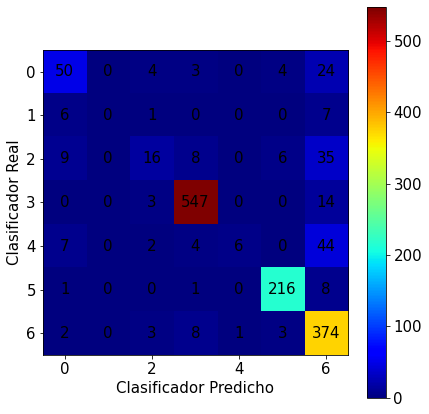

In [ ]:
plot_confusion_matrix(Y_val,y_pred)

➼ Notemos que según la matriz de confusión, las categorias que presentan peor rendimiento son la 1 y la 4 correspondientes a asco y tristeza respectivamente. Ya que en asco, el clasificador no logra acertar en ninguna prueba de las 8 y en tristeza solo obtiene 6 de 66. Siguiendo esta misma linea, en la categoria tristeza es donde se comete el mayor error, confundiendo la misma en muchos casos con neutralidad.

In [ ]:
conf_matrix_svm_norm

array([[0.03528582, 0.        , 0.00282287, 0.00211715, 0.        ,
        0.00282287, 0.01693719],
       [0.0042343 , 0.        , 0.00070572, 0.        , 0.        ,
        0.        , 0.00494001],
       [0.00635145, 0.        , 0.01129146, 0.00564573, 0.        ,
        0.0042343 , 0.02470007],
       [0.        , 0.        , 0.00211715, 0.38602682, 0.        ,
        0.        , 0.00988003],
       [0.00494001, 0.        , 0.00141143, 0.00282287, 0.0042343 ,
        0.        , 0.03105152],
       [0.00070572, 0.        , 0.        , 0.00070572, 0.        ,
        0.15243472, 0.00564573],
       [0.00141143, 0.        , 0.00211715, 0.00564573, 0.00070572,
        0.00211715, 0.2639379 ]])

➼ Si miramos la matriz de confusión normalizada, es posible cerciorarse de lo anteriormente mencionado. Mostrando además que categorias como alegría, neutralidad y sopresa tienen un alto peso en la predicción y mejor rendimiento.

➼ Ahora, si miramos las imagenes retornadas por `graph_clasification` es posible notar como son las imagenes de ambas emociones y además cual es la probabilidad de emoción otorgada por el clasificador.

In [ ]:
def graph_clasification(df_to_use,index_max,clasifier):
  contador = 0
  for index, row in df_to_use.iterrows():
    if contador < index_max:
      clasif = []
      clasif1 = []
      figs,axes = plt.subplots(1,2)
      pixel = row['pixels']
      a = list(map(int, pixel.split(' ')))[:48 * 48]
      i = np.array(a).reshape((48, 48)).astype('uint8')
      gary2rgb = cv2.cvtColor(i,cv2.COLOR_GRAY2RGB)
      resized_image = cv2.resize(gary2rgb, (150, 150))
      axes[0].imshow(resized_image)
      labels = ['enojo','asco','miedo','alegria','tristeza','sorpresa','neutral']
      landmarks_ajusted = [literal_eval(f'[{x}]') for x in row['landmark'].strip('()').split(') (')]
      for k in range(0,72):
        for j in range(0,72):
          if j>k:
            break
          dis = distance.euclidean(landmarks_ajusted[k], landmarks_ajusted[j])
          clasif.append(dis)
      clasif1.append(clasif)
      ys = []
      y = clf.predict_proba(clasif1)
      for k in y:
        for j in k:
          ys.append(100*j)
      x = np.arange(len(labels))
      axes[1].bar(x,ys,color= '#0081FF')
      axes[1].set_xticks(x)
      axes[1].set_xticklabels(labels, rotation=90, fontsize=8)
      fig.tight_layout()
      contador +=1
    else:
      break

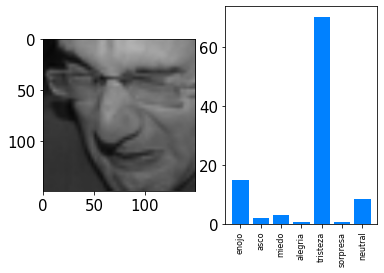

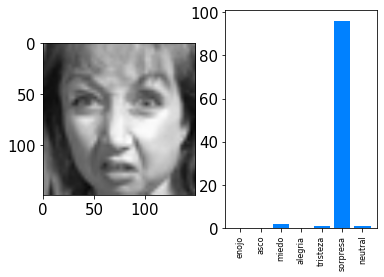

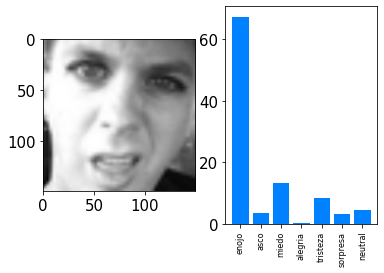

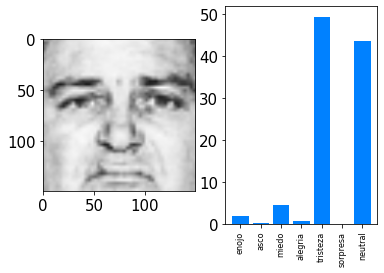

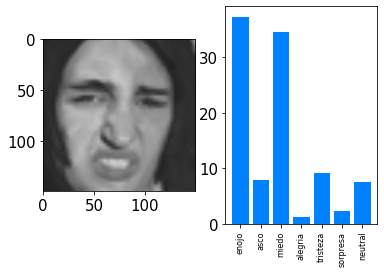

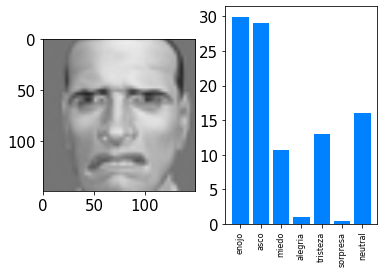

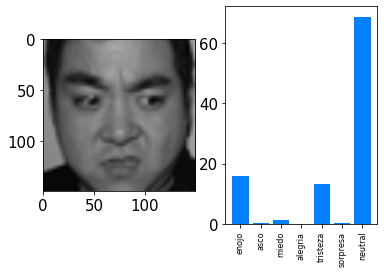

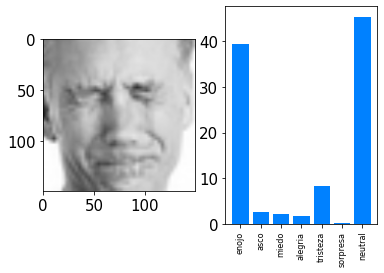

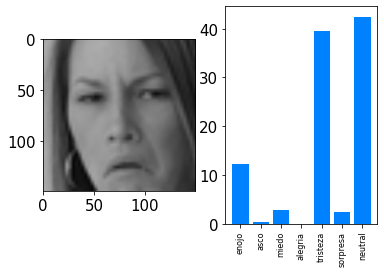

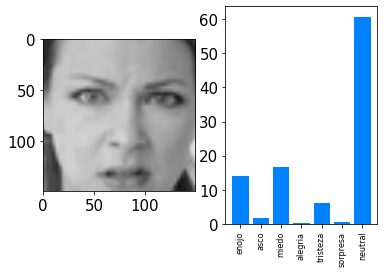

In [ ]:
graph_clasification(df_proc_asco[df_proc_asco.Usage=='ToV'],10,clf)

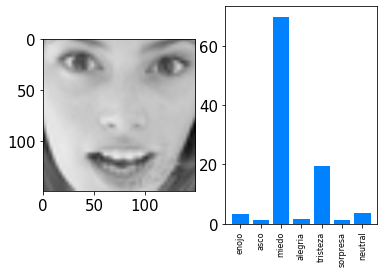

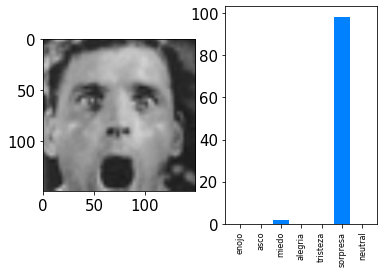

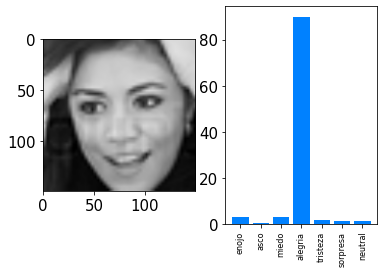

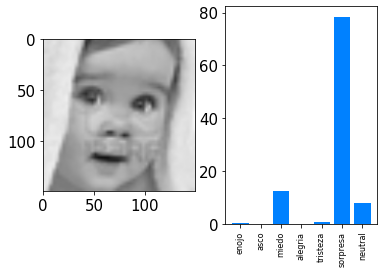

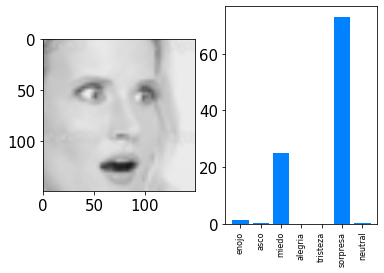

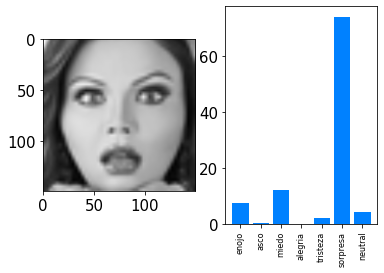

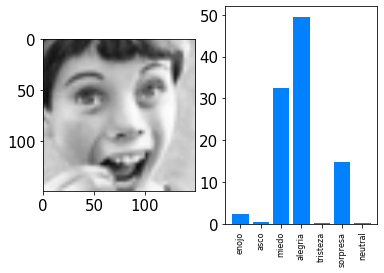

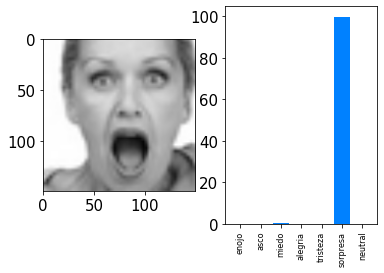

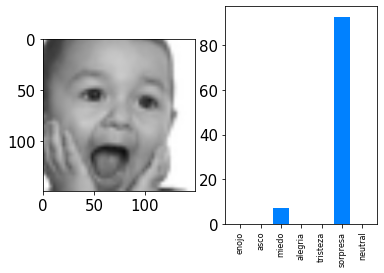

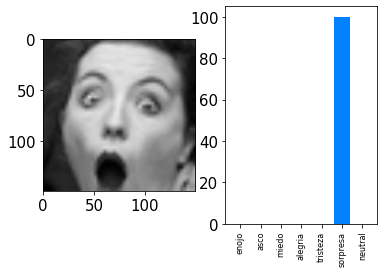

In [ ]:
graph_clasification(df_proc_sorpresa[df_proc_sorpresa.Usage=='ToV'],10,clf)

➼  Notemos que existen algunas imagenes que no representan tan bien sus emociones, y en ellas el clasificador da prioridad por otra emoción. En asco particularmente, hay imagenes que se asemejan mucho con asco y neutralidad. En cambio, en sorpresa existen caras muy similares a emociones como alegría  y miedo.

➼  Además, este error puede deberse a que estas emociones cuentan como menos datos en el set de training y en los dataframe en general.

#**Pregunta 5**

---



➼ A continuación, miremos como cambia la precisión y la matriz de confusión utilizando el set de test

In [ ]:
clf = SVC()
clf.set_params(C=100)
clf.fit(X_train,Y_train)
y_pred = clf.predict(x_matrix)
acc = accuracy_score(y_matrix, y_pred)
conf_matrix_svm1_norm = confusion_matrix(y_matrix, y_pred,normalize='all')
conf_matrix_svm1 = confusion_matrix(y_matrix, y_pred)
print(acc)

0.8577981651376146


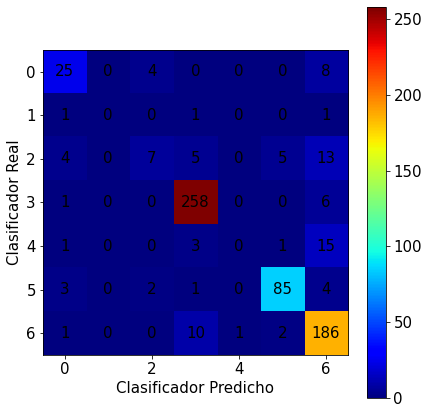

In [ ]:
plot_confusion_matrix(y_matrix,y_pred)

Es posible notar que no hubo un aumento significativo en la predicción de estos nuevos valores y la cantidad de valores clasificados se mantiene casi constante, causando problemas las mismas dos emociones anteriormente mencionadas.

Este aumento pequeño puede deberse a que existe una gran variabilidad en los datos, es decir, existe mucha varianza y el clasificador tiende a sobreajustar los mismos, clasificando los mismos de buena forma. Es decir, existe un cierto *trade-off* entre una alta varianza (*overfit*) y un alto sesgo (bajo *accuracy*).

# **Pregunta 6**

---



➼ A continuación se adjunta la arquitectura de bloques del problema con svm. En donde se explicita como funciona el problema y las correspondientes etapas del svm (kernel classification y svm training).
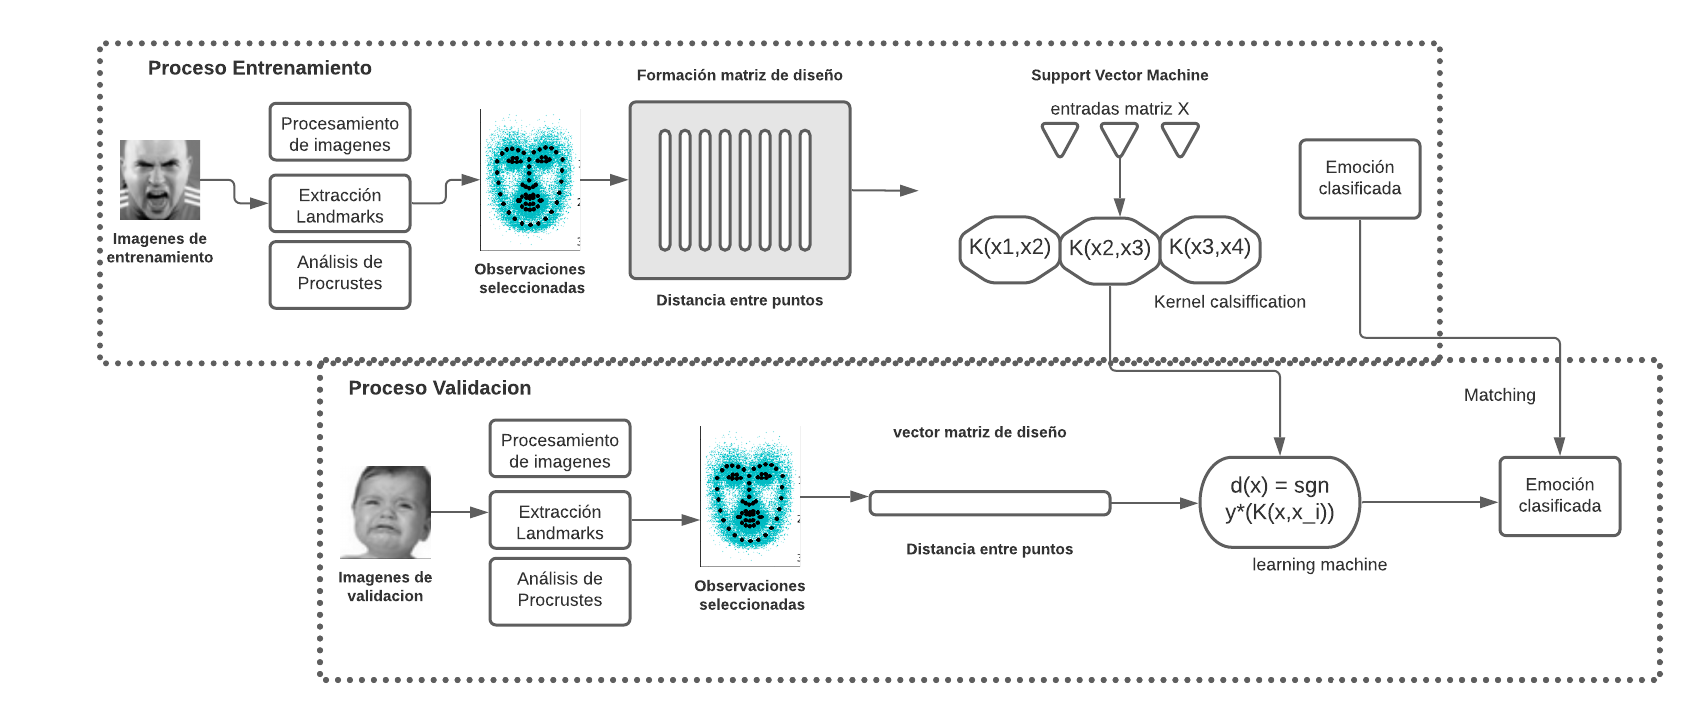

➼  Bagging y Boosting son parte de los algoritmos denominados ensamblados. Los cuales consisten en unir algoritmos simples para formar algoritmos más potentes y con mejor rendimiento. Existen diversas formas de unir algoritmos más débiles, entre ellas está Bagging y Boosting. Cada algoritmo presenta ventajas y desventajas al momento de utilizarlas, que vamos a definir a continuación. 

**Bagging:**

El principal método de Bagging es utilizar los algoritmos simples en paralelo, un ejemplo de esto es Random Forest. El objetivo de dicha estrategia es aprovechar y sacar ventaja de la independencia que existe entre los algoritmos simples, permitiendo resolver el problema independiente y escogiendo la solución que más se repita. Como se conoce, Bagging viene del concepto de agregación por bootstrap, donde se busca reducir la varianza de las estimaciones promediando estimaciones de distintos modelos o algoritmos. (1)

**Boosting:** 

El principal método de Boosting es utilizar los algoritmos simples en forma secuencial, cada algoritmo simple va delante o detrás de otro algoritmo simple, un ejemplo de esto es AdaBoost. Al contrario de Bagging, este método se aprovecha de las dependencias entre los modelos simples. En términos generales, cada modelo toma como lección los errores que han cometido los modelos previos para no volver a cometerlos. 

**Análisis comparativo**

Ambas técnicas utilizan el mismo principio: unir algoritmos simples para formar modelos mas complejos. El principal objetivo que ambos métodos tienen es mejorar el rendimiento de sus algoritmos predictivos. Sin embargo cada método utiliza su propia estrategia, mientras Bagging aprovecha la independencia de sus algoritmos más simples para predecir de mejor manera, Boosting saca ventaja de la dependencia de los mismos para no cometer los mismos errores una y otra vez. Por otro lado, una gran diferencia entre ambos algoritmos ese que Bagging apuesta por una estructura en paralelo, mientras Boosting lo hace en secuencia. En la practica podríamos implementar algoritmos más rápidos paralelizando el modelo de Bagging utilizando distintas computadoras, mientras que en Boosting debes necesariamente esperar el output del modelo anterior para ejecutar el próximo, que se traduce en mayor tiempo de espera. 
Pasando a la forma en que obtienen sus resultados ambos algoritmos, se destaca que Bagging realiza un promedio entre las respuestas de sus modelos, mientras que Boosting asigna un conjunto de ponderaciones a sus clasificadores para obtener un promedio ponderado de sus estimaciones, dando mayor peso a los algoritmos con mejores resultados en la etapa de entrenamiento. 

Teniendo en consideración lo anterior, podemos responder a la pregunta ¿Es mejor Bagging o Boosting? La respuesta es un depende, ya que cada método rinde mejor dependiendo de los datos, la simulación y las circunstancias que se está utilizando. En particular, para este set de datos buscamos tener un mejor sesgo, por lo que nos convendría tener una combinación secuencial de algoritmos versus tener uno solo. Es por aquello que Boosting es mejor opción en el problema que estamos resolviendo. Sin embargo, hay que estar atento porque al contrario de lo que pretende Bagging (disminuir el overfit) Boosting podría aumentarlo.

# **Referencias Bibliográficas**

---







1.   Ayeche, Farid & Adel, Alti. (2020). Performance Evaluation of Machine Learning for Recognizing Human Facial Emotions. Revue d'Intelligence Artificielle. 34. 267-275. 
2. Chawla, Nitesh. (2005). Discovering Knowledge in Data: An Introduction to Data Mining. 6. 10.1093/bib/6.4.411. 
3. Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) (publisher link)
4. John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55 (publisher link)
5. Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010) (publisher link)
6. Xu, Y., Goodacre, R. On Splitting Training and Validation Set: A Comparative Study of Cross-Validation, Bootstrap and Systematic Sampling for Estimating the Generalization Performance of Supervised Learning. J. Anal. Test. 2, 249–262 (2018).
7. ¿Cuál es la diferencia entre los métodos de bagging y los de boosting?, https://machinelearningparatodos.com/cual-es-la-diferencia-entre-los-metodos-de-bagging-y-los-de-boosting/, MachineLearningParaTodos, recuperado el 30 de junio del 2021, Publicado el 24 de agosto de 2020





